In [1]:
# importing libraries
import numpy as np 
import pandas as pd 
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.externals import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

C:\Users\Bhaskara\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [4]:
# loading dataset & renaming its columns
amazon = pd.read_csv("Amazon_Ratings.csv", names=['userID', 'productID','Rating','timestamp'])

# 1) Data Description

In [5]:
# dataset head
amazon.head()

,userID,productID,Rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [7]:
# dataset's shape
amazon.shape

(7824482, 4)

In [30]:
# taking a subset of the dataset
data = amazon.iloc[:1048576,0:]

# dropping timestamp columns
data = data.drop('timestamp', axis=1)

In [31]:
# checking the dataset 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048576 entries, 0 to 1048575
Data columns (total 3 columns):
userID       1048576 non-null object
productID    1048576 non-null object
Rating       1048576 non-null float64
dtypes: float64(1), object(2)
memory usage: 24.0+ MB


In [13]:
# rating summary
data.describe()['Rating']

count    1.048576e+06
mean     3.973380e+00
std      1.399329e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: Rating, dtype: float64

In [18]:
# rechecking the minimum and maximum ratings
print('Minimun rating is: {}'.format(data.Rating.min()))
print('Maximum rating is: {}'.format(data.Rating.max()))

Minimun rating is: 1.0
Maximum rating is: 5.0


In [32]:
# rechecking null values
data.isnull().sum()

userID       0
productID    0
Rating       0
dtype: int64

Text(0, 0.5, 'Total number of ratings')

Text(0.5, 1.0, 'Rating Count')

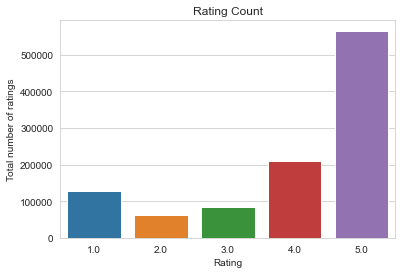

In [26]:
# on rating count by range
sns.set_style('whitegrid')
sns.countplot(data=data, x='Rating')
plt.ylabel("Total number of ratings")
plt.title('Rating Count')

In [29]:
# on total rating, user and product count
print("Total count of ratings  : ", data.shape[0])
print("Total count of users    : ",  len(np.unique(data.userID)))
print("Total count of products : ", len(np.unique(data.productID)))

Total count of ratings  :  1048576
Total count of users    :  786330
Total count of products :  61894


In [84]:
# analysis of products rated by user 
rated_products_per_user = data.groupby('userID')['Rating'].count().sort_values(ascending=False)
rated_products_per_user.head()

userID
A5JLAU2ARJ0BO     412
A231WM2Z2JL0U3    249
A25HBO5V8S8SEA    164
A6FIAB28IS79      146
AT6CZDCP4TRGA     128
Name: Rating, dtype: int64

In [85]:
# its summary
rated_products_per_user.describe()

count    786330.000000
mean          1.333506
std           1.385612
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         412.000000
Name: Rating, dtype: float64

In [86]:
# users who rates >= 50 times
print('There are {} very active users that rates products >= 50 times'.format(sum(rated_products_per_user >= 50)))

There are 38 very active users that rates products >= 50 times


In [40]:
# analysis of products rated by product
rated_products_per_product = data.groupby('productID')['Rating'].count().sort_values(ascending=False)
rated_products_per_product.head()

productID
B0002L5R78    9487
B0001FTVEK    5345
B000I68BD4    4903
B000BQ7GW8    4275
B00007E7JU    3523
Name: Rating, dtype: int64

In [41]:
# its summary
rated_products_per_product.describe()

count    61894.000000
mean        16.941481
std         89.706837
min          1.000000
25%          1.000000
50%          3.000000
75%          9.000000
max       9487.000000
Name: Rating, dtype: float64

In [90]:
# product that is rated >= 50 times
print('There are {} popular products rated >= 50 times by users'.format(sum(rated_products_per_product >= 50)))

There are 3813 popular products rated >= 50 times by users


# 2) Popularity Based Recommendation
Popularity based recommendation system works with the trend. It basically uses the items which are in trend right now. For example, if any product which is usually bought by every new user then there are chances that it may suggest that item to the user who just signed up. The problems with popularity based recommendation system is that the personalization is not available with this method i.e. even though you know the behaviour of the user you cannot recommend items accordingly.

In [112]:
# getting the new dataframe which contains products who has 50 or more ratings
popular_data = data.groupby('productID').filter(lambda x: x['Rating'].count() >= 50)
popular_data.head()

,userID,productID,Rating
183,A1BKC6B7YHYTVV,0972683275,4.0
184,AWVFSIB42LHKJ,0972683275,4.0
185,A36MQBNADRH8YY,0972683275,5.0
186,A3SRXMPLAEZ6DP,0972683275,4.0
187,A20XXTXWF2TCPY,0972683275,5.0


In [60]:
# popular data summary
popular_data.describe()

,Rating
count,677947.000000
mean,4.049815
std,1.354329
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [61]:
# creating popular product mean & count dataframe
mypopular_product = pd.DataFrame(popular_data.groupby('productID')['Rating'].mean())
mypopular_product['Rating Count'] = pd.DataFrame(popular_data.groupby('productID')['Rating'].count())
mypopular_product.head()

,Rating,Rating Count
productID,,
0972683275,4.470980,1051
1400501466,3.560000,250
1400501520,4.243902,82
1400501776,3.884892,139
1400532620,3.684211,171


In [63]:
# highest rating
mypopular_product['Rating'].max()

4.947368421052632

In [62]:
# highest count
mypopular_product['Rating Count'].max()

9487

Text(0, 0.5, 'total count')

Text(0.5, 0, 'rating range')

Text(0.5, 1.0, 'Rating Distribution')

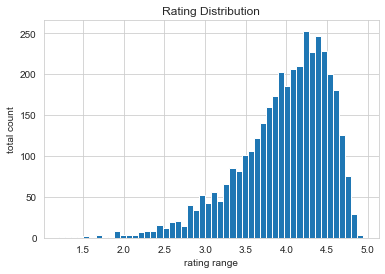

In [67]:
# on popular rating count by range
mypopular_product['Rating'].hist(bins=50)
plt.ylabel("total count")
plt.xlabel("rating range")
plt.title('Rating Distribution')

Text(0, 0.5, 'total count')

Text(0.5, 0, 'rating count range')

Text(0.5, 1.0, 'Rating Count Distribution')

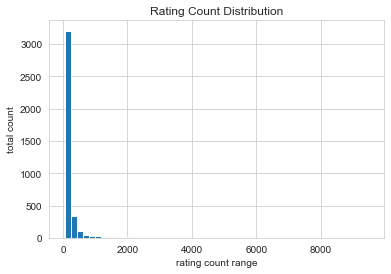

In [69]:
# on popular rating count by count
mypopular_product['Rating Count'].hist(bins=50)
plt.ylabel("total count")
plt.xlabel("rating count range")
plt.title('Rating Count Distribution')

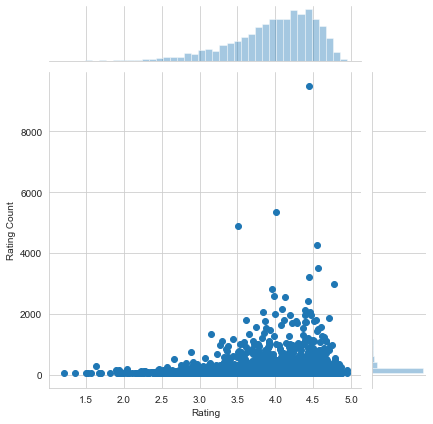

In [70]:
# its jointplot
sns.jointplot(x='Rating', y='Rating Count', data=mypopular_product)

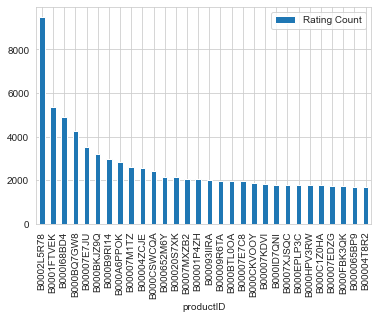

In [80]:
# top 30 most popular by count
mypopular_product.drop('Rating',axis=1).sort_values('Rating Count', ascending=False).head(30).plot(kind='bar')

In [83]:
# top 10 most popular by count (recommended)
mypopular_product.sort_values('Rating Count', ascending=False).head(10)

,Rating,Rating Count
productID,,
B0002L5R78,4.448614,9487
B0001FTVEK,4.007109,5345
B000I68BD4,3.501530,4903
B000BQ7GW8,4.553216,4275
B00007E7JU,4.565995,3523
B000BKJZ9Q,4.440509,3219
B000B9RI14,4.775701,2996
B000A6PPOK,3.950495,2828
B00007M1TZ,3.976610,2608


# 3) Collaberative Filtering.
Collaborative filtering (CF) is commonly used for recommender systems. These techniques aim to fill in the missing entries of a user-item association matrix. CF is based on the idea that the best recommendations come from people who have similar tastes. In other words, it uses historical item ratings of like-minded people to predict how someone would rate an item. CF has two sub-categories that are generally called memory-based and model-based approaches. Let's use those approaches.

## 3.1) Memory-based Collaborative Filtering (Item-Item Recommendation) 

In [92]:
# importing libraries
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
import os
from surprise.model_selection import train_test_split

In [94]:
# reading the dataset
reader = Reader(rating_scale=(1,5))
mydata = Dataset.load_from_df(popular_data, reader)

In [97]:
# splitting the dataset
trainset, testset = train_test_split(mydata, test_size=0.2, random_state=101)

In [98]:
# use user_based true/false to switch between user-based or item-based collaborative filtering
algo = KNNWithMeans(k=5, sim_options={'name':'pearson_baseline', 'user_based': False})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [110]:
# get RMSE
print('Item-Based Model (Test Set)')
print('RMSE:',accuracy.rmse(test_pred, verbose=False))

Item-Based Model (Test Set)
RMSE: 1.3454559486090034


In [100]:
# run the trained model against the testset
test_pred = algo.test(testset)
test_pred

[Prediction(uid='A3SYK7QNR78S7Q', iid='B00006I5JA', r_ui=5.0, est=4.050105373397964, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A3F6LN580OK6WL', iid='B00012O6QQ', r_ui=4.0, est=4.050105373397964, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A2IOT0LVACXBVQ', iid='B000HDQ2G6', r_ui=5.0, est=4.050105373397964, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A362Y9GGATXOOW', iid='B000BQ7GW8', r_ui=5.0, est=4.050105373397964, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='AX5EPK0DQP23Z', iid='B000AAZQJU', r_ui=3.0, est=4.130718954248366, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A17TD4LQHXD5M9', iid='B0001FTVEK', r_ui=4.0, est=4.050105373397964, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A349L2AJSRESFM', iid='B0002EXJ8Y', r_ui=5.0

## 3.2) Model-based Collaborative Filtering 

In [119]:
# sampling & creating ratings matrix
new = popular_data.head(10000)
ratings_matrix = new.pivot_table(values='Rating', index='userID', columns='productID', fill_value=0).T
ratings_matrix.head()

userID,A01852072Z7B68UHLI5UG,A0266076X6KPZ6CCHGVS,A0293130VTX2ZXA70JQS,A030530627MK66BD8V4LN,A0571176384K8RBNKGF8O,A0590501PZ7HOWJKBGQ4,A0641581307AKT5MAOU0Q,A076219533YHEV2LJO988,A0821988FXKFYX53V4QG,A099626739FNCRNHIKBCG,...,AZWOPBY75SGAM,AZX0ZDVAFMN78,AZX5LAN9JEAFF,AZX7I110AF0W2,AZXKUK895VGSM,AZXP46IB63PU8,AZYTSU42BZ7TP,AZZGJ2KMWB7R,AZZMV5VT9W7Y8,AZZST8OYL5P4Q
productID,,,,,,,,,,,,,,,,,,,,,
0972683275,0,0,5,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1400501466,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1400501520,0,0,0,0,0,0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0
1400501776,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1400532620,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [120]:
# matrix shape
ratings_matrix.shape

(76, 9832)

In [150]:
# decomposing the Matrix
from sklearn.decomposition import TruncatedSVD
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(ratings_matrix)
decomposed_matrix.shape

(76, 10)

In [122]:
# creating correlation matrix
correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(76, 76)

In [126]:
# productID purchased by customer on the 75th index
ratings_matrix.index[75]

'B00000K135'

In [127]:
# index of productID purchased by customer

i = "B00000K135"
product_names = list(ratings_matrix.index)
product_ID = product_names.index(i)
product_ID

75

In [128]:
# correlation for all items with the item purchased by this customer based on items rated by other customers people who bought the same product
correlation_product_ID = correlation_matrix[product_ID]
correlation_product_ID.shape

(76,)

In [137]:
# recommending a list that has correlation value > 0.65
Recommend = list(ratings_matrix.index[correlation_product_ID > 0.65])

# removes the item already bought by the customer
Recommend.remove(i) 

# recommends top 10 items to buy
Recommend[:10]

['B000001OM4',
 'B00000IGBF',
 'B00000J1U8',
 'B00000J3NF',
 'B00000JCT8',
 'B00000JD34',
 'B00000JDF6',
 'B00000JFE3',
 'B00000JHWX',
 'B00000JMUG']